# The  1D Time-Dependent Schrodinger Equation

The Time Dependent Schrodinger Equation with the homogeneous Dirichlet boundary is 

$$ i \hbar \frac{\partial}{\partial t} \psi(x,t) = -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\psi(x,t) + V(x) \psi(x,t) \hspace{20mm} \psi(0, t) = \psi(L,t)=0 $$ 

##  Finite Difference

Choose a discrete grid with spacing $\Delta x$ and $\Delta t$ and let $\psi_j^{m} = \psi(j\Delta x, m\Delta t)$

$$i\frac{\psi_{j}^{m+1} - \psi_{j}^{m}}{\Delta t} = - \frac{1}{2m}\frac{\psi_{j+1}^{m} -2\psi_j^m + \psi_{j-1}^{m}}{\Delta x^2} +\frac{1}{\hbar}V(x)\psi_j^m$$ 

Rearrange the equation

$$\psi_{j}^{m+1} = \psi_j^m + \frac{i}{2m}\frac{\Delta t}{\Delta x^2}\left(\psi_{j+1}^{m} -2\psi_j^m + \psi_{j-1}^{m}\right) - \frac{i}{\hbar} \Delta tV(x)\psi_j^m$$ 

## Numerical implementation

Define all parameters of interest.

In [37]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.constants as constants
import matplotlib as mpl
import numba
from numba import jit







In [30]:
# parameters setting
para_setting = {
  'k': 6e9,
  'std_dev': 9e-10,
  'x_0': -1.5e-8,
  'm': constants.m_e,


  # bounds of simulation
  'bounds': [-2e-8, 2e-8],


  # number of space steps
  'grid_number': 800,


  # time step for simulation
  'delta_t': 5e-54,


  # simulation time
  'real_time': 3e-48,


  # animation settings
  'fps': 30,
  'anim_duration': 15,

  # potential function
  'pot_func': lambda x: 0,
}

print( para_setting['m'])
print(constants.hbar)

9.1093837015e-31
1.0545718176461565e-34


In [39]:
def init_setting(para_setting):
    hbar = constants.hbar
    m = para_setting['m']

    # initial wave packet conditions
    k = para_setting['k']
    std_dev = para_setting['std_dev']
    x_0 = para_setting['x_0']

    # initialization conditions for field
    bounds = para_setting['bounds']
    grid_number = para_setting['grid_number']

    # potential
    pot_func = para_setting['pot_func']
    V = [pot_func(x) for x in np.linspace(bounds[0], bounds[1], grid_number)]
    V = np.array(V)

    # delta x and delta t for finite difference method
    delta_x = abs(bounds[1] - bounds[0]) / (grid_number - 1)
    delta_t = para_setting['delta_t']

    real_time = para_setting['real_time']
    def normalize(psi):
        I = np.sum(np.abs(psi)**2 * delta_x)
        res = psi / (I**0.5)
        return res
    def initial_condition(x):
        return normalize(np.exp(1j * k * x) * np.exp(-0.5 * ((x - x_0) / std_dev)**2))
    
    psi_initial = initial_condition(np.linspace(bounds[0], bounds[1], grid_number))
    return V,delta_x,delta_t,real_time,psi_initial,grid_number,m,hbar,bounds

# normalize such that the wave function amplitude squared is a valid PDF



In [40]:
para_setting_barrier = para_setting.copy()
para_setting_barrier['pot_func'] = lambda x: 1e17 if 0 < x < 2.5e-9 else 0
para_setting_barrier['x_0'] = -1e-8
para_setting_barrier['real_time'] = 4e-48

V,delta_x,delta_t,real_time,psi_initial,grid_number,m,hbar,bounds = init_setting(para_setting_barrier)
 


time_steps = int(real_time / delta_t)
psi = psi_initial

 

In [41]:
@numba.jit("c16[:](c16[:])", nopython=True, nogil=True)
def FDM_compute(psi):
    for t in range(0, time_steps-1):
        res = np.zeros_like(psi)
        for n in range(1, grid_number-1):
            res[n] = psi[n]+((1j)/(2*m))*(delta_t/(delta_x**2))*(psi[n + 1]-2*psi[n]+psi[n - 1])-(1j/hbar)*delta_t*V[n]*psi[n]
 
        normal = np.sum(np.absolute(res)**2)*delta_x
 
        psi = res/np.sqrt(normal)
        
    return psi 

In [42]:
start = time.time()
psi = FDM_compute(psi)
 
end = time.time()
print(end-start)

23.95838499069214


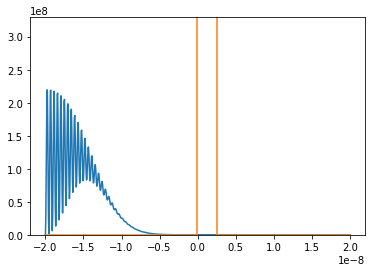

In [43]:
x = np.linspace(bounds[0], bounds[1], grid_number)
pot_func_values = [para_setting_barrier['pot_func'](xi) for xi in x]
plt.plot(x, np.absolute(psi)**2)
plt.plot(x,pot_func_values)
plt.ylim(0, max(np.absolute(psi)**2)*1.5)
plt.show()

## Make video 
#### to generate the video, we non-dimensionlize the equation

In [11]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
import scipy.constants as constants
import matplotlib as mpl
import numba
from numba import jit
from matplotlib import animation
from matplotlib.animation import PillowWriter
from scipy.linalg import eigh_tridiagonal


In [12]:
# parameters setting
para_setting = {
  'k': 6e9,
  'std_dev': 9e-10,
  'x_0': -1.5e-8,
  'm': constants.m_e,


  # bounds of simulation
  'bounds': [-2e-8, 2e-8],


  # number of space steps
  'grid_number': 300,


  # time step for simulation
  'delta_t': 5e-54,


  # simulation time
  'real_time': 3e-48,


  # animation settings
  'fps': 30,
  'anim_duration': 15,

  # potential function
  'pot_func': lambda x: 0,
}

In [13]:
def init_setting(para_setting):
    hbar = constants.hbar
    m = para_setting['m']

    # initial wave packet conditions
    k = para_setting['k']
    std_dev = para_setting['std_dev']
    x_0 = para_setting['x_0']

    # initialization conditions for field
    bounds = para_setting['bounds']
    grid_number = para_setting['grid_number']

    # potential
    pot_func = para_setting['pot_func']
    V = [pot_func(x) for x in np.linspace(bounds[0], bounds[1], grid_number)]
    V = np.array(V)

    # delta x and delta t for finite difference method
    delta_x = abs(bounds[1] - bounds[0]) / (grid_number - 1)
    delta_t = para_setting['delta_t']

    real_time = para_setting['real_time']
    def normalize(psi):
        I = np.sum(np.abs(psi)**2 * delta_x)
        res = psi / (I**0.5)
        return res
    def initial_condition(x):
        return normalize(np.exp(1j * k * x) * np.exp(-0.5 * ((x - x_0) / std_dev)**2))
    
    psi_initial = initial_condition(np.linspace(bounds[0], bounds[1], grid_number))
    return V,delta_x,delta_t,real_time,psi_initial,grid_number,m,hbar,bounds

# normalize such that the wave function amplitude squared is a valid PDF



In [14]:
para_setting_barrier = para_setting.copy()
para_setting_barrier['pot_func'] = lambda x: 1e17 if 0 < x < 2.5e-9 else 0
para_setting_barrier['x_0'] = -1e-8
para_setting_barrier['real_time'] = 4e-48/8

V,delta_x,delta_t,real_time,psi_initial,grid_number,m,hbar,bounds = init_setting(para_setting_barrier)
 


time_steps = int(real_time / delta_t)

psi = np.zeros([time_steps,grid_number],dtype=np.complex128)
psi[0] = psi_initial

 

In [15]:
@numba.jit("c16[:, :](c16[:, :])", nopython=True, nogil=True)
def FDM_compute(psi):
    for t in range(0, time_steps-1):
        for n in range(1, grid_number-1):
            psi[t+1][n] = psi[t][n]+((1j)/(2*m))*(delta_t/delta_x**2)*(psi[t][n + 1] - 2 * psi[t][n] + psi[t][n - 1]) -(1j / hbar) * delta_t * V[n] * psi[t][n]
        
        normal = np.sum(np.absolute(psi[t+1])**2)*delta_x
        for n in range(1, grid_number-1):
            psi[t+1][n] = psi[t+1][n]/np.sqrt(normal)
        
    return psi
    

 

 


In [16]:
start = time.time()
psi = FDM_compute(psi)
 
end = time.time()
print(end-start)

0.9598665237426758


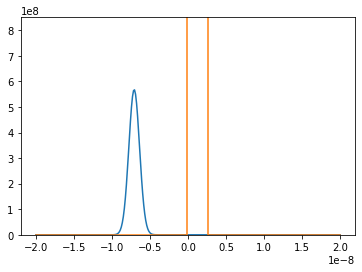

In [17]:
x = np.linspace(bounds[0], bounds[1], grid_number)
pot_func_values = [para_setting_barrier['pot_func'](xi) for xi in x]
plt.plot(x, np.absolute(psi[-1])**2)
plt.plot(x,pot_func_values)
plt.ylim(0, max(np.absolute(psi[-1])**2)*1.5)
plt.show()

In [31]:
print(psi.shape)
print(type(psi))

(100000, 300)
<class 'numpy.ndarray'>


In [32]:
# def animate(i):
#     ln1.set_data(x, np.absolute(psi[100*i])**2)
     
#     time_text.set_text('$(10^4 mL^2)^{-1}t=$'+'{:.1f}'.format(100*i*delta_t*1e4))
     
    
# fig, ax = plt.subplots(1,1, figsize=(8,4))
# #ax.grid()
# ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='fdm')
 
# time_text = ax.text(0.65, 16, '', fontsize=15,
#            bbox=dict(facecolor='white', edgecolor='black'))
# ax.set_ylim(0, max(np.absolute(psi[-1])**2)*5)
# ax.set_xlim(-2e-8,2e-8)
# ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
# ax.set_xlabel('$x/L$', fontsize=20)
# ax.legend(loc='upper left')
# ax.set_title('$(mL^2)V(x) = -10^4 \cdot n(x, \mu=L/2, \sigma=L/20)$')
# plt.tight_layout()
# ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
# ani.save('pen_1.gif',writer='pillow',fps=50,dpi=100)
